BDMLtools构建lasso回归模型  <font size=3 >by 曾珂</font>

**环境**:
+ **OS**: macOS Big Sur 11.5.2
+ **CPU**: 2GHz 四核Intel Core i5
+ **内存**: 16G

In [1]:
import pandas as pd
import numpy as np
import BDMLtools as bm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
print("BDMLtools v"+str(bm.__version__))

BDMLtools v0.4.1


# 1 数据说明
+ 此数据为外国某消费金融公司的某个人消费类贷款产品数据,客群大多拥有信用记录,要求在贷款准入节点构建评分卡评估客群信用风险,为贷中审批,授信定价提供参考。

+ 原始数据包括客户的申请信息,外部数据,征信信息,历史申请信息(若有),历史贷款表现(若有)五类信息,分散于不同的表中,这里已经进行了特征构建与宽表构建

+ 原始数据共20万样本,5000多个特征,这里为简化选择原数据中的122个特征与随机3万的样本演示

+ 特征含义见下:


```
1.信用综合分
 score1:外部信用评分1
 score2:外部信用评分2
 score3:外部信用评分3
``` 

# 2 数据处理

以Pipline工作流的形式进行数据处理,各个函数作用请见其文档

    Step 1.dtStandardization:实体一致性转换
    Step 2.dtypeAllocator:列类型分配转换
    Step 3.nanTransformer:缺失值处理
    Step 4.outliersTransformer:异常值处理

In [3]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    
    [('1.dtStandardization',bm.dtStandardization(id_col=['ID'],drop_dup=True)), 
                 
     ('2.dtypeAllocator', bm.dtypeAllocator(dtypes_dict={})),
                 
     ('3.nanTransformer',bm.nanTransformer(method=('constant','constant'),
                                         missing_values=[np.nan,np.inf,-np.inf,'nan','','special','missing'],
                                         fill_value=(0,'missing'),#填补缺失值为0
                                         indicator=False)),
    
     ('4.outliersTransformer', bm.outliersTransformer())     
    ])

In [4]:
dat=pipe.fit_transform(pd.read_csv('data/creditdata_small.csv')[['Score1','Score2','Score3','ID','TARGET']])

# 3 数据分区

本案例只考虑in-sample分区

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test=train_test_split(dat.drop('TARGET',axis=1),
                                                  dat['TARGET'],
                                                  test_size=0.33, 
                                                  random_state=1223,stratify=dat['TARGET'])

# 4 预拟合模型

bm.prefitModel为预拟合模型，提供了在不进行任何特征筛选的前提下使用全量数据建模以预估模型效果的功能

若后续特征筛选过程合理则模型表现不会差距过多，甚至会比预拟合模型好

+ 此步骤并非必须
+ 默认使用lightgbm作为训练算法
+ 更多详请请见帮助文档

In [7]:
p_model=bm.prefitModel(method='floor').fit(X_train,y_train)

+ 模型表现

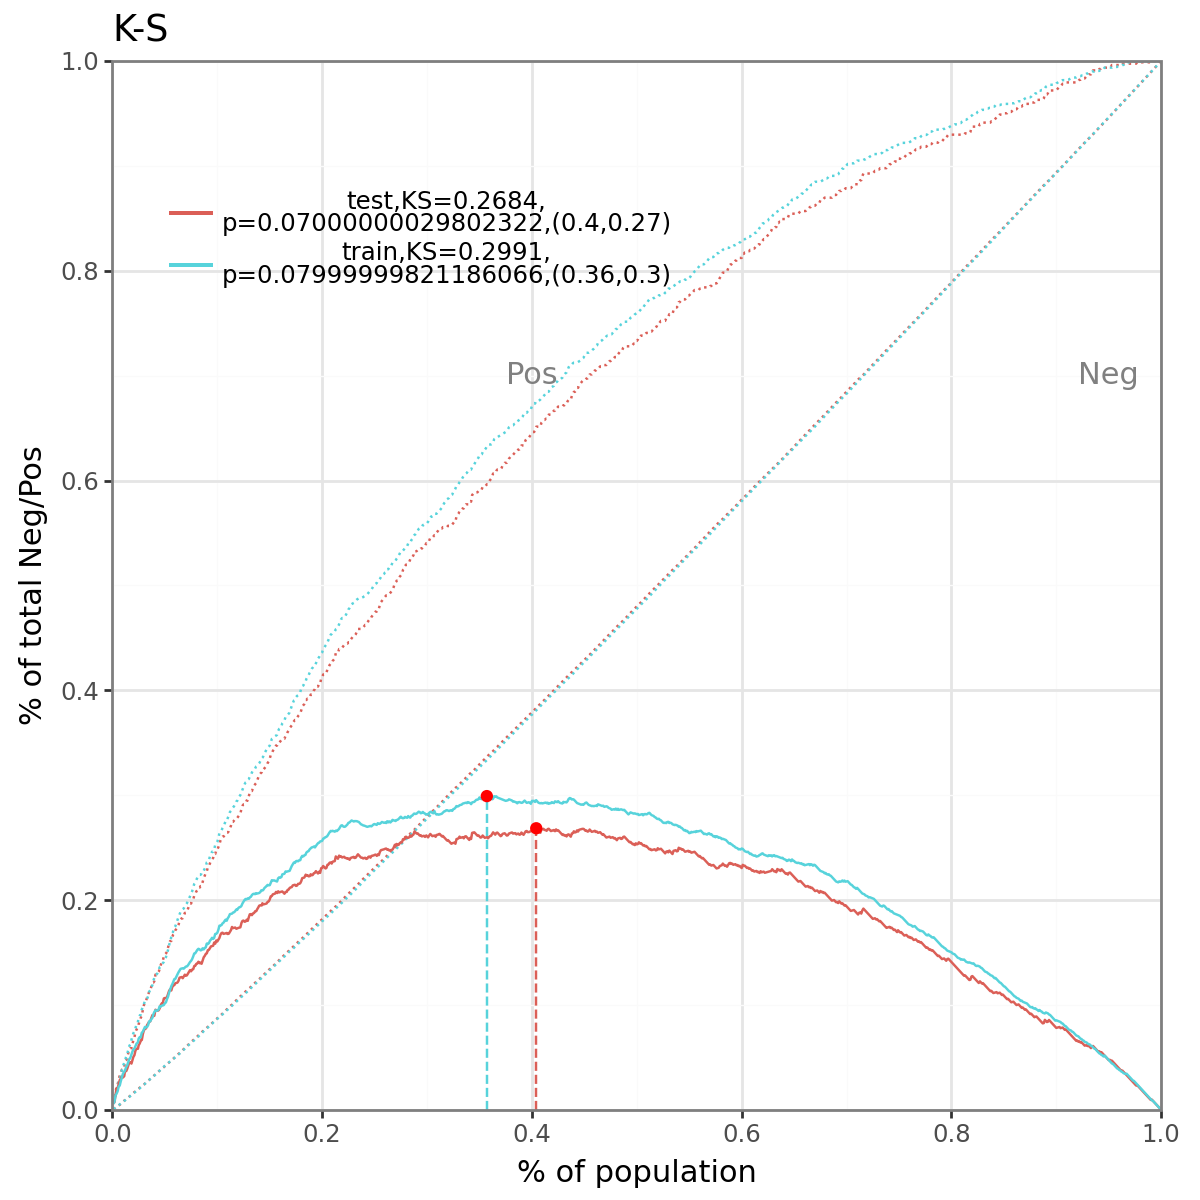

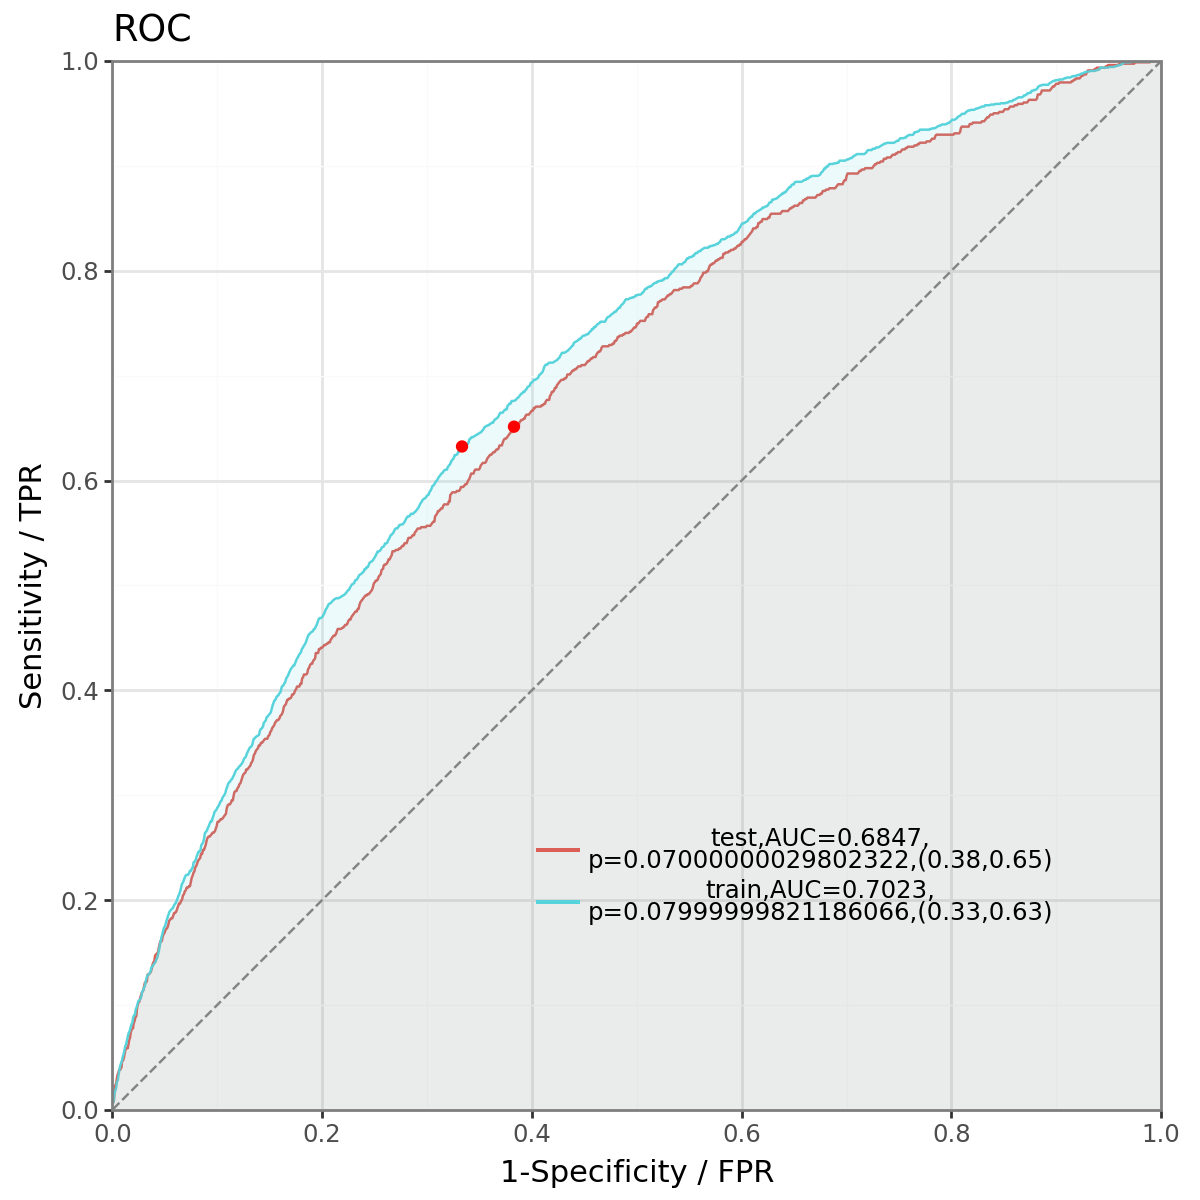

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [8]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(p_model.predict_proba(X_train),index=X_train.index),
    pd.Series(p_model.predict_proba(X_test),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) #可以看到test数据上ks与auc的情况,此结果可作为模型结果的参考值

# 5 建模

## 5.1 介绍

通过回归损失函数中加入正则项，以加入偏差(bias)的代价换取更好的鲁棒性，回归算法可衍生如下三种常见的正则回归:

    + 岭回归(Ridge):加入L2正则
    + 拉松回归(Lasso):加入L1正则
    + 弹性网络(Elastic-Net):加入L1和L2正则，并以系数控制两种正则的权重
        
其中Lasso回归的系数可收缩至0的特点使其能够进行变量筛选，从而适用于入模特征较多的情形。在数字化风控领域，Lasso回归是一种常见的融合模型工具。

BDMLtools利用sklearn提供的Lasso回归模型、交叉验证、plotnine提供的绘图基础库整合了基于交叉验证的Lasso回归，提供了通过交叉验证自动需要最优模型，同时完成变量筛选与后续模型结果的图形展示等的功能。

In [9]:
%%time
lasso=bm.LassoLogit(c_num=100,
                    method='best',
                    standard=False,
                    metric='neglogloss',
                    cv=5
                   ).fit_plot(X_train,y_train)

CPU times: user 1.1 s, sys: 238 ms, total: 1.34 s
Wall time: 13.6 s


上述模型参数含义如下:
+ c_num=20,int:l1正则项的粒度，越大的数值代表越多的l1正则项参与寻优
+ method='1se':str,若c_num非None，LassoLogit进行重新拟合时的c值
    + '1se':一倍标准误差原则，同R的glmnet。交叉验证中最优指标(logloss或其他优化指标)下的c值对应一倍标准误差范围内的最小c值在全量数据上拟合的模型 
    + 'best':交叉验证中最优指标(logloss或其他优化指标)下的c值在全量数据上拟合的模型   
+ standard=True:bool,是否进行数据标准化。
+ metric:str,交叉验证评估标准，可选'roc_auc','neglogloss'
+ cv:int,交叉验证的折数

需要注意的有以下几点

+ c_num越多越多的C值被遍历但也会提高计算量，默认n_jobs=-1以便对交叉验证进行并行处理
+ 回归类算法普遍不能支持缺失值，因此建模前对数据填补了缺失值
+ 1se为一倍标准误差原则，详情请参考glmnet帮助文档:https://glmnet.stanford.edu/articles/glmnet.html
+ 算法使用saga(随机梯度下降)进行系数求解，因此需要进行数据标准化以使算法快速收敛。原始数据已经进行了标准化这里设定standard为False

## 5.2 Lasso收缩路径

Lasso的回归系数路径可以使用方法lasso.plot_path实现

图中x轴为log(C)值，y轴为系数值，x副坐标轴为相应系数训练的模型的非0系数个数(仅限于linux与mac)

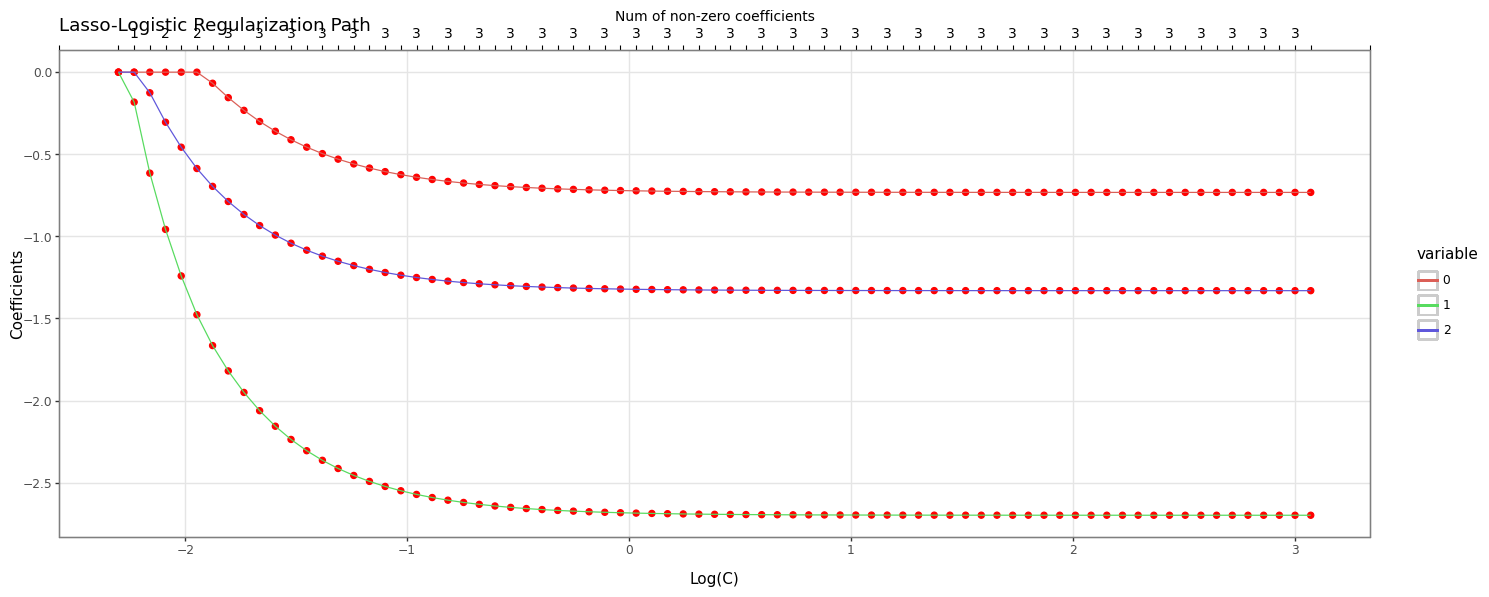

In [10]:
lasso.plot_path

系数收缩的明细数据,该表索引为C值,数字列代表按照顺序相应变量在指定C值下的回归系数,coef_cnt代表非0的系数个数

In [11]:
lasso.cv_path_

,log(C),0,1,2,coef_cnt
C,,,,,
0.000118,-3.927422,0.000000,0.000000,0.000000,0
0.000139,-3.856715,0.000000,0.000000,0.000000,0
0.000164,-3.786008,0.000000,0.000000,0.000000,0
0.000193,-3.715300,0.000000,0.000000,0.000000,0
0.000227,-3.644593,0.000000,0.000000,0.000000,0
...,...,...,...,...,...
616.240195,2.789750,-0.732317,-2.698479,-1.330735,3
725.198827,2.860457,-0.732319,-2.698483,-1.330738,3
853.422647,2.931164,-0.732321,-2.698486,-1.330739,3


## 5.3 Lasso的交叉验证

Lasso的交叉验证结果可以使用方法lasso.plot_valscore实现
图中x轴为log(C)值，y轴为交叉验证指标，x副坐标轴为相应系数训练的模型的非0系数个数(仅限于linux与mac)

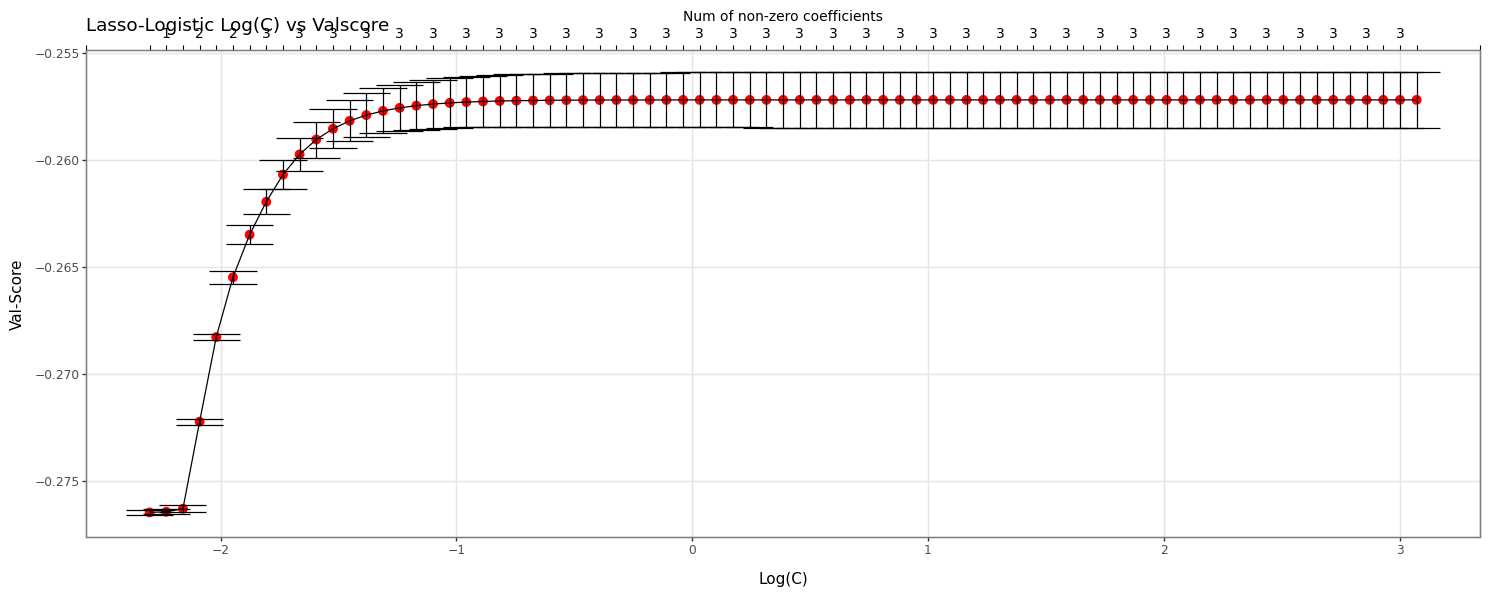

In [12]:
lasso.plot_valscore

交叉验证的明细数据,C值、log(C)值分别为C值与log10(C)值，valscore_avg、std、err分别为交叉验证指标的平均值、标准差与标准误差，coef_cnt代表非0的系数个数

In [13]:
lasso.cv_res_

,C,log(C),valscore_avg,valscore_std,valscore_err,coef_cnt
C,,,,,,
0.000118,0.000118,-3.927422,-0.278031,0.001545,0.000773,0
0.000139,0.000139,-3.856715,-0.278036,0.001558,0.000779,0
0.000164,0.000164,-3.786008,-0.278043,0.001573,0.000786,0
0.000193,0.000193,-3.715300,-0.278052,0.001586,0.000793,0
0.000227,0.000227,-3.644593,-0.278053,0.001590,0.000795,0
...,...,...,...,...,...,...
616.240195,616.240195,2.789750,-0.257210,0.002593,0.001296,3
725.198827,725.198827,2.860457,-0.257210,0.002593,0.001296,3
853.422647,853.422647,2.931164,-0.257210,0.002593,0.001296,3


## 选择C值

默认情况下bm.LassoLogit将根据最优C值或其一倍标准误差内最小的C值为准选择模型

In [14]:
lasso.model_refit

LogisticRegression(C=6.455829355495021, max_iter=1000000, penalty='l1',
                   random_state=123, solver='saga', tol=1e-06)

In [15]:
lasso.coef_#回归系数

Score1   -0.730724
Score2   -2.696324
Score3   -1.329369
dtype: float64

同时bm.LassoLogit提供了方法select_C可根据交叉验证结果选择合适的C值并输出模型

此时算法回选择相应C值下的模型作为refit模型

In [16]:
print(lasso.c_1se) #一倍标准误差内最小的C值

0.035263529609778244


In [17]:
lasso.select_C(C=lasso.c_1se)

In [18]:
lasso.model_refit

LogisticRegression(C=0.035263529609778244, max_iter=1000000, penalty='l1',
                   random_state=123, solver='saga', tol=1e-06)

In [19]:
lasso.coef_#回归系数

Score1   -0.456881
Score2   -2.305472
Score3   -1.084262
dtype: float64

# 6.模型评估

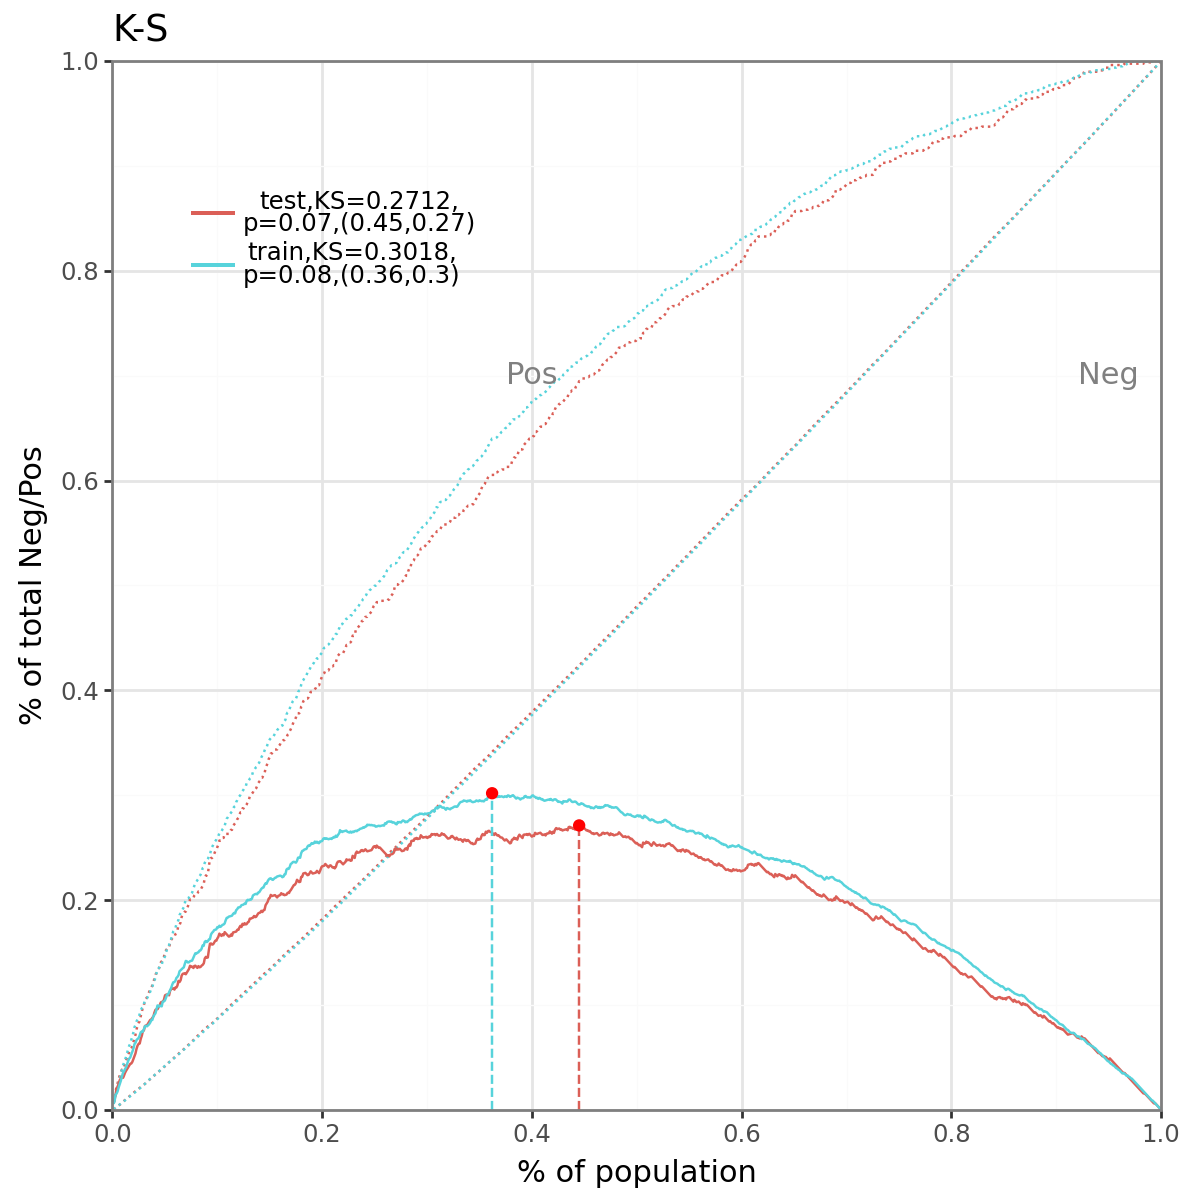

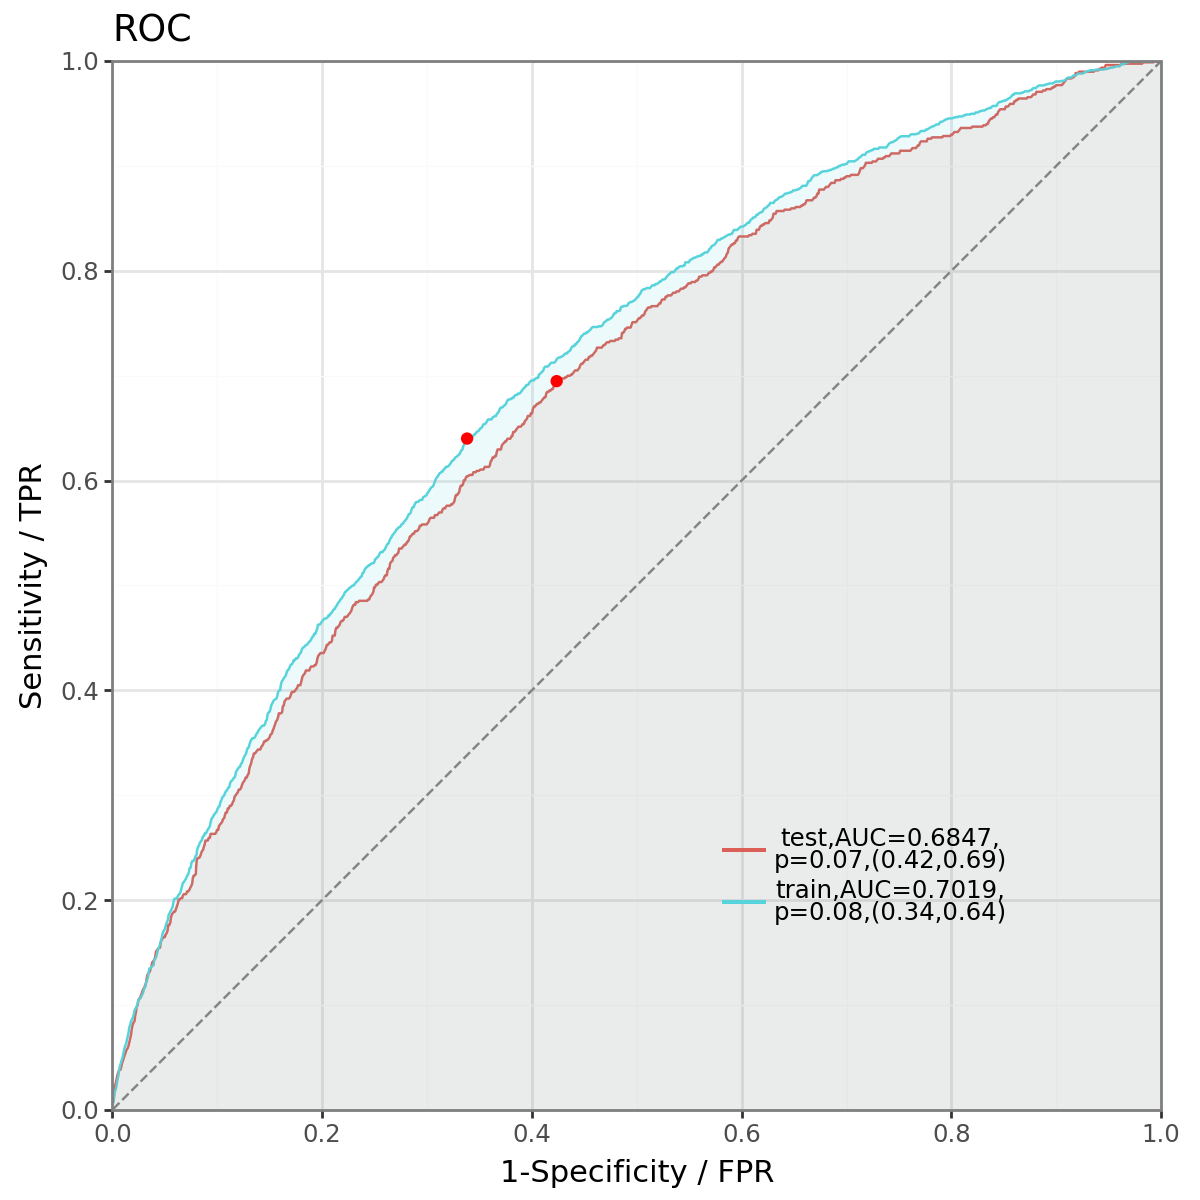

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [20]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(lasso.model_refit.predict_proba(X_train.to_numpy())[:,1],index=X_train.index),
    pd.Series(lasso.model_refit.predict_proba(X_test.to_numpy())[:,1],index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 